In [120]:
import paddle
import numpy as np 
import math

paddle.set_device('cpu')

mm = paddle.nn.Sequential(
    paddle.nn.BatchNorm2D(3),
    paddle.nn.Conv2D(3, 10, 3, 2)
)

for k in mm.state_dict().keys():
    print(k)



pg0, pg1, pg2 = [], [], []  # optimizer parameter groups
for k, v in mm.named_sublayers():
    print(k, v)
    if hasattr(v, 'bias') and isinstance(v.bias, paddle.fluid.framework.Parameter):
        pg2.append(v.bias)  # biases
    if isinstance(v, paddle.nn.BatchNorm2D):
        pg0.append(v.weight)  # no decay
    elif hasattr(v, 'weight') and isinstance(v.weight, paddle.fluid.framework.Parameter):
        pg1.append(v.weight)  # apply decay


# optimizer0 = paddle.optimizer.Adam(learning_rate=0.1, parameters=pg0, beta1=0.937, beta2=0.999)
# optimizer1 = paddle.optimizer.Adam(learning_rate=0.1, parameters=pg1, beta1=0.937, beta2=0.999, weight_decay=0.0005)
# optimizer2 = paddle.optimizer.Adam(learning_rate=0.1, parameters=pg2, beta1=0.937, beta2=0.999)


opt0 = paddle.optimizer.Momentum(learning_rate=0.01, momentum=0.937, parameters=pg0, use_nesterov=True)
opt1 = paddle.optimizer.Momentum(learning_rate=0.01, momentum=0.937, parameters=pg1, use_nesterov=True, weight_decay=0.0005)
opt2 = paddle.optimizer.Momentum(learning_rate=0.01, momentum=0.937, parameters=pg2, use_nesterov=True)
optimizers = [opt0, opt1, opt2]



hyp = {
    'lr0': 0.01,
    'lrf': 0.01,
    'warmup_bias_lr': 0.1,
    'warmup_momentum': 0.8,
    'warmup_epochs': 3,
    'momentum': 0.937,
    'weight_decay': 0.0005,

    'epochs': 300,
    'total_batch_size': 8 * 8,
}

# nbs = 64  # nominal batch size
# accumulate = max(round(nbs / hyp['total_batch_size']), 1)  # accumulate loss before optimizing
# hyp['weight_decay'] *= hyp['total_batch_size' * accumulate / nbs  # scale weight_decay

def one_cycle(y1=0.0, y2=1.0, steps=100):
    return lambda x: ((1 - math.cos(x * math.pi / steps)) / 2) * (y2 - y1) + y1

lf = lambda x: (1 - x / (hyp['epochs'] - 1)) * (1.0 - hyp['lrf']) + hyp['lrf']
lf = one_cycle(1, hyp['lrf'], hyp['epochs']) 

scheduler = paddle.optimizer.lr.LambdaDecay(learning_rate=0.01, lr_lambda=lf)


# num_batches = len(datalaoder)
num_batches = 30
max_batches = 10  # 1%

nw = max(round(hyp['warmup_epochs'] * num_batches), max_batches)
initial_lr = [hyp['lr0'], hyp['lr0'], hyp['lr0']]



lrs = [[], [], []]
moments = [[], [], []]

for epoch in range(hyp['epochs']):
    for i in range(num_batches):

        ni = i + num_batches * epoch

        # # Warmup
        if ni <= nw:
            xi = [0, nw]  # x interp
            for j, opt in enumerate(optimizers):
                # bias lr falls from 0.1 to lr0, all other lrs rise from 0.0 to lr0
                _lr = np.interp(ni, xi, [hyp['warmup_bias_lr'] if j == 2 else 0.0, initial_lr[j] * lf(epoch)])
                opt.set_lr(_lr)

                if hasattr(opt, '_momentum'):
                    opt._momentum = np.interp(ni, xi, [hyp['warmup_momentum'], hyp['momentum']])
                    
                lrs[j].append(opt.get_lr())
                
        else:
            
            for i, x in enumerate(lrs):
                lrs[i].append(scheduler.get_lr())
                
        for i, opt in enumerate(optimizers):
            if hasattr(opt, '_momentum'):
                moments[i].append(getattr(opt, '_momentum'))
            
    for opt in optimizers:
        opt.set_lr( scheduler.get_lr() )

    scheduler.step()
    


0.weight
0.bias
0._mean
0._variance
1.weight
1.bias
0 <paddle.nn.layer.norm.BatchNorm2D object at 0x13c919900>
1 <paddle.nn.layer.conv.Conv2D object at 0x13d48f360>


In [121]:
import matplotlib.pyplot as plt

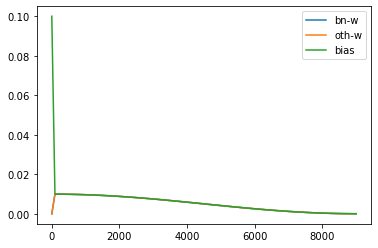

0.00010027141164071552


In [122]:
labels = ['bn-w', 'oth-w', 'bias']
for i in range(len(lrs)):
    plt.plot(lrs[i], label=labels[i])

plt.legend()
plt.show()

print(lrs[0][-1])

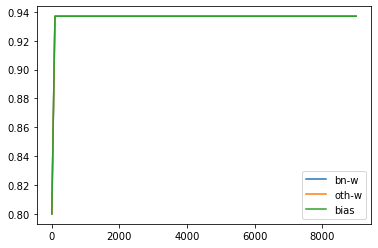

In [116]:
labels = ['bn-w', 'oth-w', 'bias']
for i in range(len(moments)):
    plt.plot(moments[i], label=labels[i])

plt.legend()
plt.show()

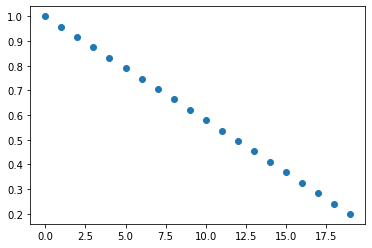

In [50]:
lf = lambda x: (1 - x / (hyp['epochs'] - 1)) * (1.0 - hyp['lrf']) + hyp['lrf']

x = list(range(20))
y = [lf(i) for i in x]
plt.scatter(x, y)

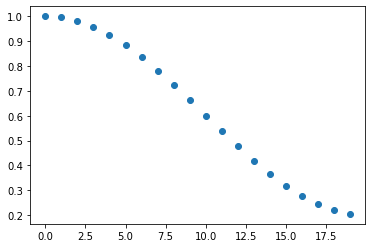

In [52]:
def one_cycle(y1=0.0, y2=1.0, steps=100):
    return lambda x: ((1 - math.cos(x * math.pi / steps)) / 2) * (y2 - y1) + y1

lf = one_cycle(1, hyp['lrf'], hyp['epochs']) 

x = list(range(20))
y = [lf(i) for i in x]
plt.scatter(x, y)